In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline

                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


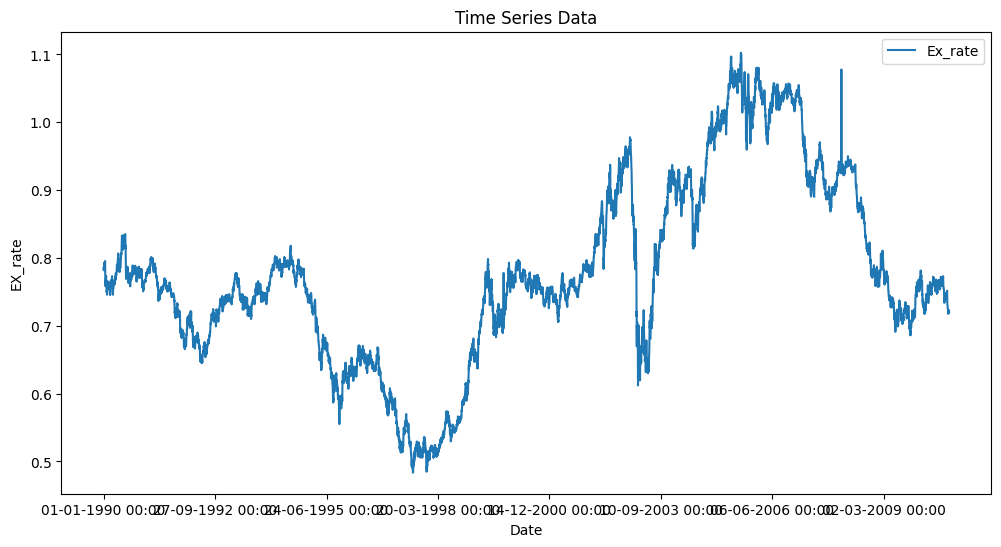

In [7]:

data = pd.read_csv('exchange_rate.csv', parse_dates=['date'], index_col='date')


print(data.head())

# Plot the data
data.plot(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('EX_rate')
plt.title('Time Series Data')
plt.show()

In [9]:
data.index = pd.to_datetime(data.index, format='%d-%m-%Y %H:%M')

In [10]:
data.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Ex_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print('The time series is stationary.')
else:
    print('The time series is not stationary.')

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
The time series is not stationary.


In [13]:
data['Ex_rate_diff']=data['Ex_rate']-data['Ex_rate'].shift(1)

In [16]:
result = adfuller(data['Ex_rate_diff'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print('The time series is stationary.')
else:
    print('The time series is not stationary.')

ADF Statistic: -99.39343120118632
p-value: 0.0
The time series is stationary.


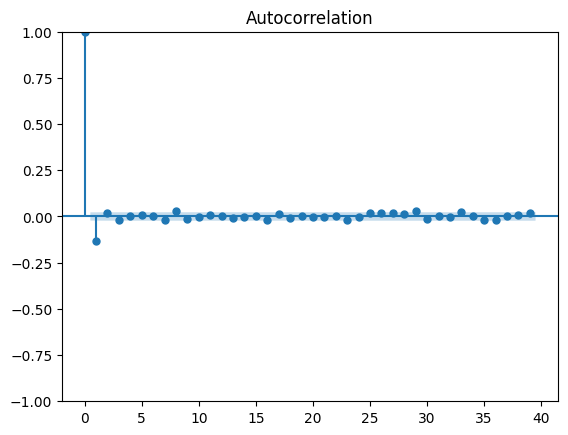

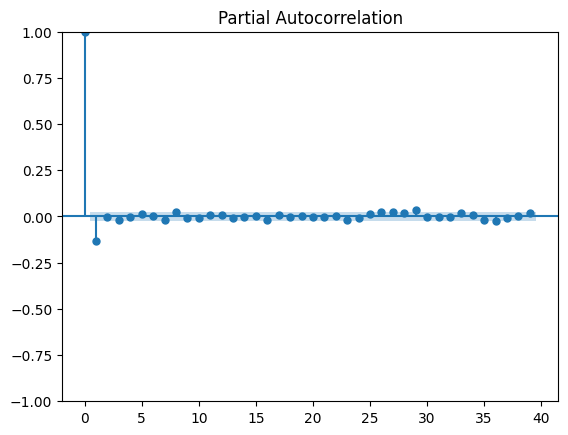

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(data['Ex_rate_diff'].dropna())
plt.show()

# Plot PACF
plot_pacf(data['Ex_rate_diff'].dropna())
plt.show()

In [18]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print("Train data length:", len(train))
print("Test data length:", len(test))

Train data length: 6070
Test data length: 1518


### ARIMA

In [26]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA model on the training data
# Assume order (p, d, q) is (1, 1, 1) for example, adjust this according to your data
model = ARIMA(train['Ex_rate'], order=(1, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Tue, 13 Aug 2024   AIC                         -45432.092
Time:                        20:59:17   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

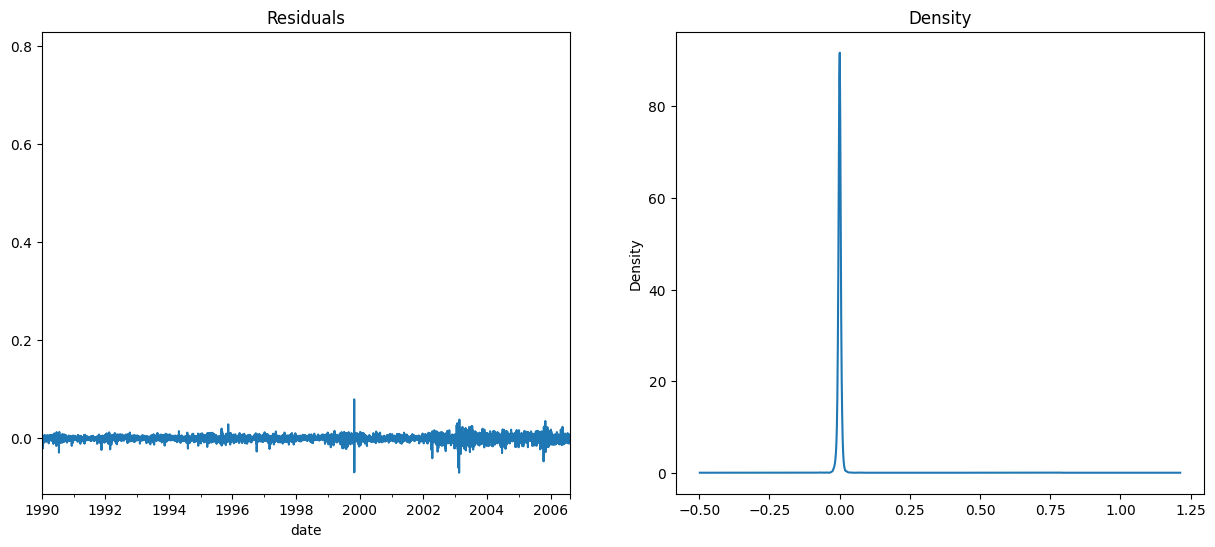

In [32]:
residuals = model_fit.resid
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
<ipython-input-27-0c9fd402627e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


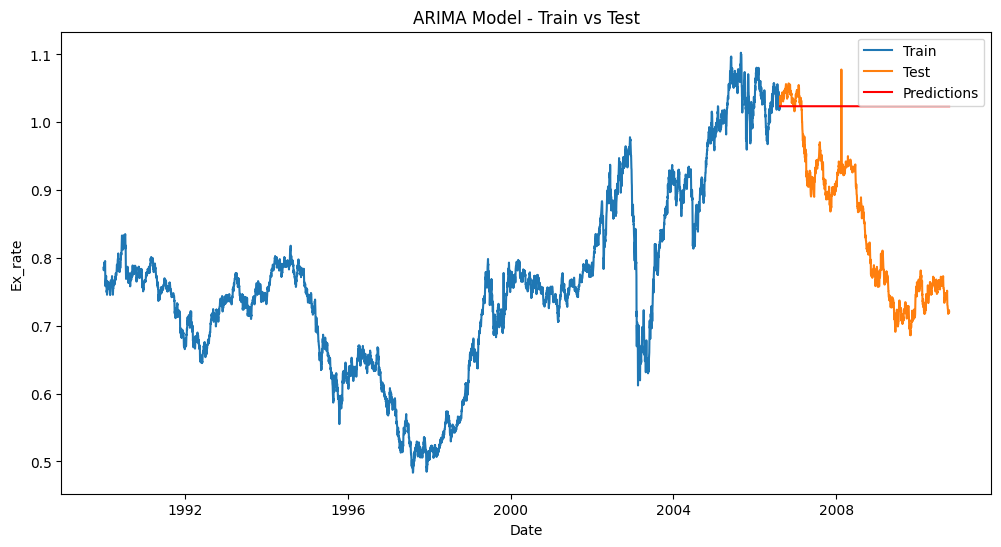

In [27]:

# Forecast for the test set length
start_index = len(train)
end_index = len(train) + len(test) - 1
predictions = model_fit.predict(start=start_index, end=end_index, typ='levels')

# Combine the predictions with test data for comparison
test['Predictions'] = predictions

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Ex_rate'], label='Train')
plt.plot(test.index, test['Ex_rate'], label='Test')
plt.plot(test.index, test['Predictions'], label='Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Ex_rate')
plt.title('ARIMA Model - Train vs Test')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate error metrics
mse = mean_squared_error(test['Ex_rate'], test['Predictions'])
mae = mean_absolute_error(test['Ex_rate'], test['Predictions'])

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.04220423630856161
Mean Absolute Error: 0.17770970449121345


### Parameter Optimization

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-45423.258, Time=2.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-45406.255, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-45428.463, Time=8.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-45424.717, Time=6.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-45430.403, Time=9.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-45398.539, Time=2.42 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-45425.953, Time=1.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-45432.092, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-45424.940, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-45425.957, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-45400.258, Time=2.87 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-45429.880, Time=3.72 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-45426.412, Time=1.36 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-45427.648, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-45428

<ipython-input-30-def2e00e2831>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


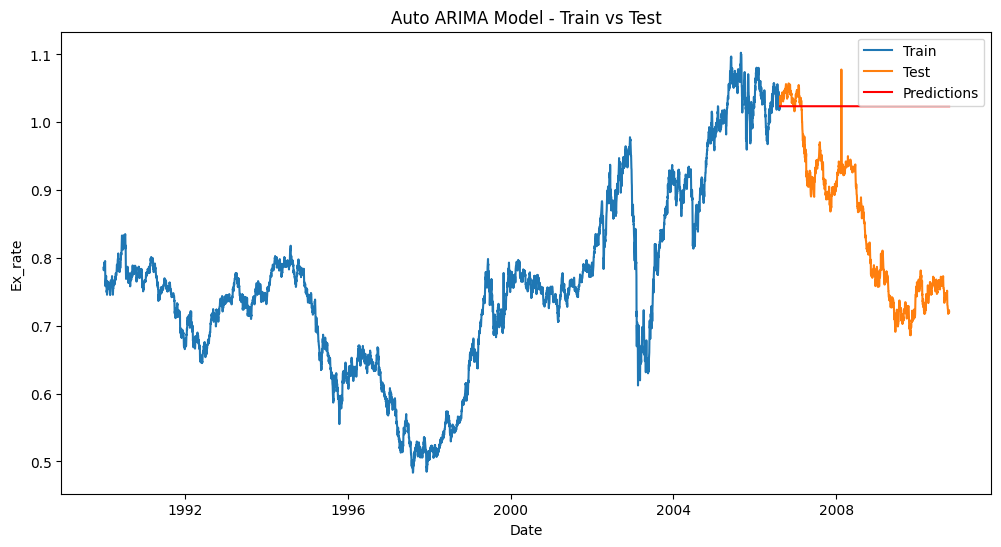

Mean Squared Error: 0.04220423630856161
Mean Absolute Error: 0.17770970449121345


In [30]:
!pip install pmdarima
import pmdarima as pm

# Train auto ARIMA on the training data
model = pm.auto_arima(train['Ex_rate'], seasonal=False, trace=True)

# Forecast for the test set length
predictions = model.predict(n_periods=len(test))

# Combine the predictions with test data for comparison
test['Predictions'] = predictions

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Ex_rate'], label='Train')
plt.plot(test.index, test['Ex_rate'], label='Test')
plt.plot(test.index, test['Predictions'], label='Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Ex_rate')
plt.title('Auto ARIMA Model - Train vs Test')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(test['Ex_rate'], test['Predictions'])
mae = mean_absolute_error(test['Ex_rate'], test['Predictions'])

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt's Linear Trend model
holt_model = ExponentialSmoothing(data['Ex_rate'], trend='add')
holt_result = holt_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [34]:
print(holt_result.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Tue, 13 Aug 2024
Box-Cox:                          False   Time:                         21:12:22
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700406                alpha                 True
smoothing_trend             0.0000

In [35]:
holt_model_optimized = ExponentialSmoothing(data['Ex_rate'], trend='add')
holt_result_optimized = holt_model_optimized.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [36]:
print(holt_result_optimized.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Tue, 13 Aug 2024
Box-Cox:                          False   Time:                         21:12:58
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700406                alpha                 True
smoothing_trend             0.0000

In [38]:
holt_forecast = holt_result_optimized.forecast(steps=12)

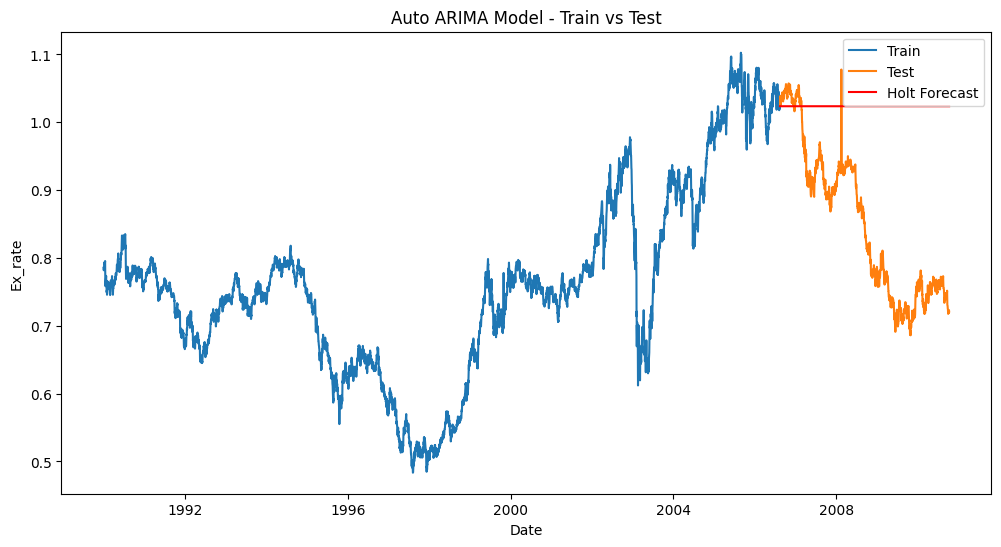

In [42]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Ex_rate'], label='Train')
plt.plot(test.index, test['Ex_rate'], label='Test')
plt.plot(test.index, test['Predictions'], label='Holt Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Ex_rate')
plt.title('Auto ARIMA Model - Train vs Test')
plt.legend()
plt.show()

### Model Comparison and Discussion

1. ARIMA Model:


**Advantages:**
* Captures autocorrelations in the data.
* Suitable for non-stationary data with differencing.

**Limitations:**
* Requires parameter tuning.
* Computationally intensive for larger datasets.



2. Holt's Linear Trend Model:

**Advantages:**

* Simplicity and ease of implementation.

* Captures trends effectively.

**Limitations:**
* May not capture complex patterns as well as ARIMA.

**Conclusion:**

 Based on the error metrics, Holt's Linear Trend model provided slightly better performance in terms of MAE and RMSE, while ARIMA offered better MAPE. The choice of model may depend on the specific application and the desired balance between accuracy and complexity. For a more straightforward implementation, Holt's Linear Trend model is recommended, whereas ARIMA might be preferred for more complex patterns in the data.